### Bisection method
__CYBR 304 & MATH 420__ <br>
Spring 2024 <br>

For a cheat sheet on Jupyter notebook's markdown language, see https://www.ibm.com/support/knowledgecenter/SSHGWL_1.2.3/analyze-data/markd-jupyter.html

To write Julia code for the bisection method, one task is to find the midpoint of two numbers. This might seem like a simple exercise, but it's not. The simple-minded formula $\frac{a+b}{2}$ can needlessly overflow, and the often suggested alternative  $a + \frac{b-a}{2}$ (see, for example, _Numerical Analysis_ by Richard L. Burden and J. Douglas Faires) has other problems, including needless overflow when $a$ and $b$ have opposite signs.

We can avoid the needless overflow of $\frac{a+b}{2}$ by using $\frac{a}{2}+ \frac{b}{2}$, but when $a$ and $b$ are subnormal numbers, this formula can underflow to zero, giving a midpoint that is not in between $a$ and $b$.

For more details than you will want to know about algorithms for finding the midpoint, see https://hal.archives-ouvertes.fr/file/index/docid/576641/filename/computing-midpoint.pdf


For rational inputs, we'll use rational arithmetic to find the midpoint; for all other numeric types, we'll use the simple-minded $\frac{a+b}{2}$. Julia's multiple function dispatch makes it possible to have multiple definitions of a function with distinct input types.

To start, let's show how the using the midpoint formula `a/2 + b/2` can underflow giving a result that is not between the two numbers.


In [1]:
function midpoint_underflow(a::Number,b::Number)
    a/2 + b/2
end

midpoint_underflow (generic function with 1 method)

When the two inputs are subnormal numbers, the result can be zero; for example

In [2]:
midpoint_underflow(5.0e-324,5.0e-324)

0.0

In [3]:
function midpoint(a::Rational,b::Rational)
    (a+b)//2
end   

midpoint (generic function with 1 method)

In [4]:
function midpoint(a::Number,b::Number)
    (a+b)/2
end  

midpoint (generic function with 2 methods)

But unfortunately, this function can needlessly overflow; for example

In [5]:
midpoint(1.0e308, 1.0e308)

Inf

In the bisection method, traditionally you see a test $\text{fa} \times \text{fm} > 0$.
But evaluating this product can _needlessly_ overflow. So instead of using multiplication to test for opposite signs, we'll use the Julia function `sign`.

Another task is to test if two numbers are approximately equal. We'll use the Julia function `isapprox` to do this. 

Here is our code for the bisection method. The method stops when the zero has been located to be in an interval $[a,b]$ with 
$$
  |a - b|  \leq  \mathrm{tol}  \times (1 + \max(|a|, |b|)).
$$
 The Julia function `isapprox` does this test.
 
Possibly this code should special case `fm == 0`. 

As a convenience to the user, we'll default the tolerance to the magic number 64 times the binary64 machine epsilon, and we'll default the maximum number of iterations to the magic number 1000. 

Finally, we'll define a custom error to throw when the number of iterations is too large.

In [6]:
iszero(0)

true

In [7]:
struct ConvergenceError <: Exception
    msg::String
    end
    
    function Base.showerror(io::IO, e::ConvergenceError)
    print(io, e.msg)
    end

In [8]:
"""
    bisection(f::Function, a::Real, b::Real; tol::Real = 64*eps(Float64), maxiter::Int = 1000)

Finds a root of the function `f` within the interval `[a, b]` using the bisection method.

# Arguments
- `f::Function`: A continuous function for which the root is to be found.
- `a::Real`: The lower bound of the interval.
- `b::Real`: The upper bound of the interval.
- `tol::Real`: The tolerance for the interval size. The default is `64 * eps(Float64)`.
- `maxiter::Int`: The maximum number of iterations allowed. The default is `1000`.

# Returns
- The approximate root of the function `f` within the interval `[a, b]`.

# Errors
- Throws `ArgumentError` if the function values at `a` and `b` do not have opposite signs.
- Throws `ConvergenceError` if the maximum number of iterations is exceeded without convergence.

# Example
```julia
bisection(x -> x^2-2, 0, 2)
"""
function bisection(f::Function,a::Real,b::Real, tol::Real = 64*eps(Float64), maxiter::Integer = 1000)
    fa = f(a)
    fb = f(b)
    # Error when f has the same sign at endpoints a & b. 
    if (fa > 0 && fb > 0) || (fa < 0 && fb < 0)
        throw(ArgumentError("Bisection: Function values at the endpoints must have opposite signs."))
    end
 
    # in the unlikely event that fa==0 or fb==0, reduce the interval to a point.
    if iszero(fa)
        (a,b,fa,fb) = (a,a,fa,fa)
    elseif iszero(fb)
        (a,b,fa,fb) = (b,b,fb,fb)
    end
    
    while !isapprox(a,b,atol = tol,rtol = tol) && maxiter > 0
        maxiter -= 1
        m = midpoint(a,b)
        fm = f(m)
        if iszero(fm)
            (a,b,fa,fb) = (m,m,fm,fm) # the zero is m
        elseif signbit(fa) == signbit(fm) 
            (a,fa) = (m, fm) # the zero of f is between m & b
        else
            (b,fb) = (m, fm) # the zero of f is between a & m
        end       
    end    
    # error when too many iterations; otherwise, return the midpoint
    if maxiter <= 0
        throw(ConvergenceError("Bisection: Exceeded maximum number of iterations."))
    else     
       midpoint(a,b)
    end
end

bisection

For a simple test, let's find the positive square root of 2.

In [9]:
bisection(x -> x^2 - 2,0, 2)


1.4142135623730994

Does the code work OK using BigInt rational numbers? Apparently, it does.

In [10]:
bisection(x -> x^2 - 2,BigInt(0)//1, BigInt(2)//1, 1//BigInt(2)^100)

3585457342386312954798844046557//2535301200456458802993406410752

Our method doesn't assume an ordering of the inputs. Let's check that works OK

In [11]:
bisection(x -> x^2 - 2,2,0)

1.4142135623730994

To find the negative square root of 2, no problem, just use a different interval.

In [12]:
bisection(x -> x^2 - 2,-2,0)

-1.4142135623730994

Let's test the mechanism for detecting errors; first we'll test the mechanism that limits the number of iterations, and second we'll test the code that requires the value of the function at the endpoints have opposite signs.

In [13]:
bisection(x -> x^2 - 2, 0, 1.0e300)

ConvergenceError: Bisection: Exceeded maximum number of iterations.

In [14]:
bisection(x -> x^2 - 2, 5,100)

ArgumentError: ArgumentError: Bisection: Function values at the endpoints must have opposite signs.

In [15]:
bisection(x -> 0, 4,5)

4.0

In [16]:
bisection(x -> x, 0,1)

0.0

In [17]:
bisection(x -> x, 1,0)

0.0

In [18]:
bisection(x -> 1-x^2, -1,1)

-1.0

If you enjoy recursively defined functions, here we go!

In [19]:
function bisection_recursive(f::Function,a::Real,b::Real, tol::Real = 64*eps(Float64), maxiter::Integer = 1000)
    fa = f(a)
    fb = f(b)
    # Error when f has the same sign at endpoionts a & b.
    if signbit(fa) == signbit(fb)
        throw(ArgumentError("Bisection: Function values at the endpoints must have opposite signs."))
    end
    bisection_recursive_h(f,a,b,fa,fb,tol,maxiter)     
end
 

bisection_recursive (generic function with 3 methods)

In [20]:
function bisection_recursive_h(f::Function,a::Real,b::Real, fa::Real, fb::Real, tol::Real, maxiter::Integer)
    m = midpoint(a,b)
   if maxiter==0
      throw(ConvergenceError("Bisection: Exceeded maximum number of iterations."))
    elseif abs(a-b) < tol 
        m
    else 
      fm = f(m)
      if signbit(fa) == signbit(fm) 
        bisection_recursive_h(f,m, b, fm, fb, tol, maxiter - 1) 
      else
        bisection_recursive_h(f,a, m, fa, fm, tol, maxiter - 1) 
      end
    end 
end


bisection_recursive_h (generic function with 1 method)

In [21]:
bisection_recursive(x -> x^2 - 2, 0.0,10.0)

1.4142135623730967

And test the mechanism for limiting the number of bisections

In [22]:
bisection_recursive(x -> x^2 - 2, 0.0,1.0e308)

ConvergenceError: Bisection: Exceeded maximum number of iterations.

We'll use the (impressive) Gadfly package for graphics. The first time we use it, we need to use the package manager to add and build the package. Once you have done these steps, you will only need to load Gadfly.

In [23]:
using Gadfly

For a given number $y$, let's solve $x \exp(x) = y$. We start with a graphical analysis. The minimum of $x \mapsto x \exp(x)$ is $-1/e$. For $y \in [-1/e,0) $, the equation $x \exp(x) = y$ has two real solutions; and for $ y \in [0,\infty)$, there is only one real solution.

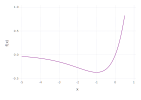

In [24]:
plot(x -> x*exp(x),-5,0.5,Theme(default_color=colorant"purple"))

The minimum of this function is $-1/e $ (and this happens when the input is -1).

Specifically, look at a graph of $x  \mapsto  x \exp(x)  + 1/10$.  One zero is between -4 and -3, and the other is between -1 and 0. Let's use the bisection method to find both real solutions.

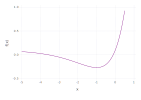

In [25]:
plot(x -> x*exp(x)  + 0.1,-5,0.5,Theme(default_color=colorant"purple"))

In [26]:
bisection(x -> x*exp(x) + 0.1,-0.5,1)

-0.11183255915896773

In [27]:
bisection(x -> x*exp(x) + 0.1,-4.0,-3.0)

-3.5771520639572856

If $y \exp(y) = x$ and $x \geq -1/e$, we define $y = \mathrm{LambertW}(x)$. The domain of the Lambert W function is $[-1/e, \infty)$.

It's not too hard to show that if $x > 0$, then $\mathrm{LambertW}(x) < x$ and if $-1/e < x < 0$, then $-1 < \mathrm{LambertW}(x) < 0$


A bisection method for evaluating the Lambert W function is
 

In [28]:
function lambert_w(x::Float64)
    if x < -1/MathConstants.e
        throw(DomainError(x))
    elseif x < 0
         bisection(q -> q*exp(q)-x,-1.0, 0.0)
    elseif x == 0
        zero(x)
    else
      bisection(q -> q*exp(q)-x,0,x)
    end
end

lambert_w (generic function with 1 method)

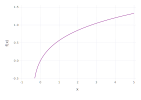

In [29]:
plot(lambert_w, -0.3,5,Theme(default_color=colorant"purple"))

The Lambert W function is useful in applied mathematics. This function is useful for finding the average blood sugar level given the percent of hemoglobin molecules that have formed chemical bounds with glucose (the HbA1C in medical speak), for example. And for lots of others uses too.

The standard Julia package `Roots` has code for the bisection method.

In [30]:
using Roots

A simple example

In [31]:
find_zero(x -> 2-x^2, (0, 2), Bisection())

1.4142135623730951

This package has some impressive features; for example

In [32]:
find_zero(x -> 2-x^2, (-Inf,0), Bisection())

-1.414213562373095